In [1]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, MaxPool1D, Concatenate, Activation, Add, GlobalAveragePooling1D, \
    Dense, LSTM, TimeDistributed, Reshape, BatchNormalization, Bidirectional, Flatten, MaxPooling1D, Dropout, \
    SeparableConv1D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction

In [2]:
# CNN Model
def cnn(x_shape,
        n_classes,
        filters,
        fc_hidden_nodes,
        learning_rate=0.01, regularization_rate=0.01,
        metrics=None):
    if metrics is None:
        metrics = ['accuracy']
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    dim_output = n_classes
    weightinit = 'lecun_uniform'  # weight initialization
    m = Sequential()

    m.add(BatchNormalization(input_shape=(dim_length, dim_channels)))
    for filter_number in filters:
        m.add(Conv1D(filter_number, kernel_size=3, padding='same',
                     kernel_regularizer=l2(regularization_rate),
                     kernel_initializer=weightinit))
        m.add(BatchNormalization())
        m.add(Activation('relu'))
    m.add(Flatten())
    m.add(Dense(units=fc_hidden_nodes,
                kernel_regularizer=l2(regularization_rate),
                kernel_initializer=weightinit))  # Fully connected layer
    m.add(Activation('relu'))  # Relu activation
    m.add(Dense(units=dim_output, kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate)))
    m.add(BatchNormalization())
    m.add(Activation(out_activ))  # Final classification layer

    m.compile(loss=out_loss,
              optimizer=Adam(lr=learning_rate),
              metrics=metrics)

    return m


# CNN-LSTM Model
def cnn_lstm(x_shape,
             n_classes,
             n_hidden=128,
             learning_rate=0.01,
             n_steps=4,
             length=32,
             n_signals=9,
             regularization_rate=0.01,
             cnn_depth=3,
             lstm_depth=2,
             metrics=['accuracy']):
    """ CNN1D_LSTM version 1: Divide 1 window into several smaller frames, then apply CNN to each frame
    - Input data format: [None, n_frames, n_timesteps, n_signals]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(Reshape((n_steps, length, n_signals), input_shape=_input_shape))
    m.add(BatchNormalization())
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    m.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
    m.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
    m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    m.add(TimeDistributed(Flatten()))
    for _ in range(lstm_depth-1):
        m.add(LSTM(n_hidden, return_sequences=True,
                   kernel_regularizer=l2(regularization_rate)))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.5))
    m.add(Dense(100, activation='relu',
                kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    return m


# Vanilla LSTM Model
def vanilla_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 metrics=['accuracy']):
    """ Requires 3D data: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(LSTM(n_hidden))
    m.add(Dropout(0.3))
    m.add(Dense(100, activation='relu'))
    m.add(Dense(n_classes, activation=out_activ, kernel_regularizer=l2(regularization_rate)))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=metrics)
    return m


# Stacked LSTM Model
def stacked_lstm(x_shape,
                 n_classes,
                 n_hidden=128,
                 learning_rate=0.01,
                 regularization_rate=0.01,
                 depth=2,
                 metrics=['accuracy']):
    """ Require 3D data: [n_samples, n_timesteps, n_signals]"""
    _input_shape = x_shape[1:]
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    dim_output = n_classes
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Dense(100, activation='relu', name='preprocess', kernel_regularizer=l2(regularization_rate)))
    m.add(LSTM(n_hidden, return_sequences=True, kernel_regularizer=l2(regularization_rate)))
    m.add(Dropout(0.5))
    m.add(LSTM(n_hidden))
    m.add(Dense(100, activation='relu'))
    m.add(Dense(dim_output, activation=out_activ, name="output"))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)
    return m


# BiLSTM Model
def bilstm(x_shape,
           n_classes,
           n_hidden=128,
           learning_rate=0.01,
           regularization_rate=0.01,
           merge_mode='concat',
           depth=2,
           metrics=['accuracy']):
    """ Requires 3D data: [n_samples, n_timesteps, n_features]"""

    _input_shape = x_shape[1:]
    m = Sequential()

    m.add(BatchNormalization(input_shape=_input_shape))
    m.add(Bidirectional(LSTM(n_hidden), merge_mode=merge_mode))
    m.add(Dense(100, activation='relu', kernel_regularizer=l2(regularization_rate)))
    m.add(Dense(n_classes, activation=out_activ))

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m


# iSPLInception Model
def ispl_inception(x_shape,
                   n_classes,
                   filters_number,
                   network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy']):
    dim_length = x_shape[1]  # number of samples in a time series
    dim_channels = x_shape[2]  # number of channels
    weightinit = 'lecun_uniform'  # weight initialization

    def inception_module(input_tensor, stride=1, activation='relu'):

        # The  channel number is greater than 1
        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=bottleneck_size,
                                     kernel_size=1,
                                     padding='same',
                                     activation=activation,
                                     kernel_initializer=weightinit,

                                     use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_sizes = [max_kernel_size // (2 ** i) for i in range(3)]
        conv_list = []

        for kernel_size in kernel_sizes:
            conv_list.append(Conv1D(filters=filters_number,
                                    kernel_size=kernel_size,
                                    strides=stride,
                                    padding='same',
                                    activation=activation,
                                    kernel_initializer=weightinit,
                                    kernel_regularizer=l2(regularization_rate),
                                    use_bias=False)(input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_last = Conv1D(filters=filters_number,
                           kernel_size=1,
                           padding='same',
                           activation=activation,
                           kernel_initializer=weightinit,
                           kernel_regularizer=l2(regularization_rate),
                           use_bias=False)(max_pool_1)

        conv_list.append(conv_last)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]),
                            kernel_size=1,
                            padding='same',
                            kernel_initializer=weightinit,
                            kernel_regularizer=l2(regularization_rate),
                            use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    # Build the actual model:
    input_layer = Input((dim_length, dim_channels))
    x = BatchNormalization()(input_layer)  # Added batchnorm (not in original paper)
    input_res = x

    for depth in range(network_depth):
        x = inception_module(x)

        if use_residual and depth % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x

    gap_layer = GlobalAveragePooling1D()(x)

    # Final classification layer
    output_layer = Dense(n_classes, activation=out_activ,
                         kernel_initializer=weightinit, kernel_regularizer=l2(regularization_rate))(gap_layer)

    # Create model and compile
    m = Model(inputs=input_layer, outputs=output_layer)

    m.compile(loss=out_loss,
              optimizer=Adam(learning_rate=learning_rate, amsgrad=True),
              metrics=metrics)

    return m

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

df = pd.read_csv("D:/HAR/WISDM/WISDM.csv", index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [4]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'], dtype='object')

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
df['activity'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,2,131623331483000,9.000000,-1.570000,1.690000
1098200,19,2,131623371431000,9.040000,-1.460000,1.730000
1098201,19,2,131623411592000,9.080000,-1.380000,1.690000
1098202,19,2,131623491487000,9.000000,-1.460000,1.730000


In [6]:
df['activity'].value_counts()

activity
5    424397
1    342176
4    122869
0    100427
2     59939
3     48395
Name: count, dtype: int64

In [7]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [8]:
import numpy as np

def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        # Finding the most frequent label within the segment
        segment_labels = df[label_name][i:i+time_steps].values
        label = np.bincount(segment_labels).argmax()
        
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [9]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'
X_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
X_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((20334, 80, 3), (20334,), (7118, 80, 3), (7118,))

In [11]:
n_classes = 6

In [12]:
use_residual = True
use_bottleneck = True
learning_rate = 0.0005
regularization_rate = 0.00593,
network_depth = 5
filters_number = 64
max_kernel_size = 68,
use_residual = 'use_residual', 
use_bottleneck = 'use_bottleneck'
out_loss = CategoricalCrossentropy(reduction=Reduction.AUTO, name='output_loss')
out_activ = 'softmax'

In [13]:
model = ispl_inception(X_train.shape, n_classes, filters_number, network_depth=5,
                   use_residual=True,
                   use_bottleneck=True,
                   max_kernel_size=20,
                   learning_rate=0.01,
                   bottleneck_size=32,
                   regularization_rate=0.01,
                   metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 3)]              0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 80, 3)                12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 80, 32)               96        ['batch_normalization[0][0]'] 
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 80, 3)                0         ['batch_normalization[0][0

                                                                    ]                             
                                                                                                  
 add (Add)                   (None, 80, 256)              0         ['batch_normalization_4[0][0]'
                                                                    , 'activation_2[0][0]']       
                                                                                                  
 activation_3 (Activation)   (None, 80, 256)              0         ['add[0][0]']                 
                                                                                                  
 conv1d_16 (Conv1D)          (None, 80, 32)               8192      ['activation_3[0][0]']        
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 80, 256)              0         ['activation_3[0][0]']        
 g1D)     

In [18]:
epochs = 10
num_classes = 6

In [19]:
from tensorflow.keras.utils import to_categorical

y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


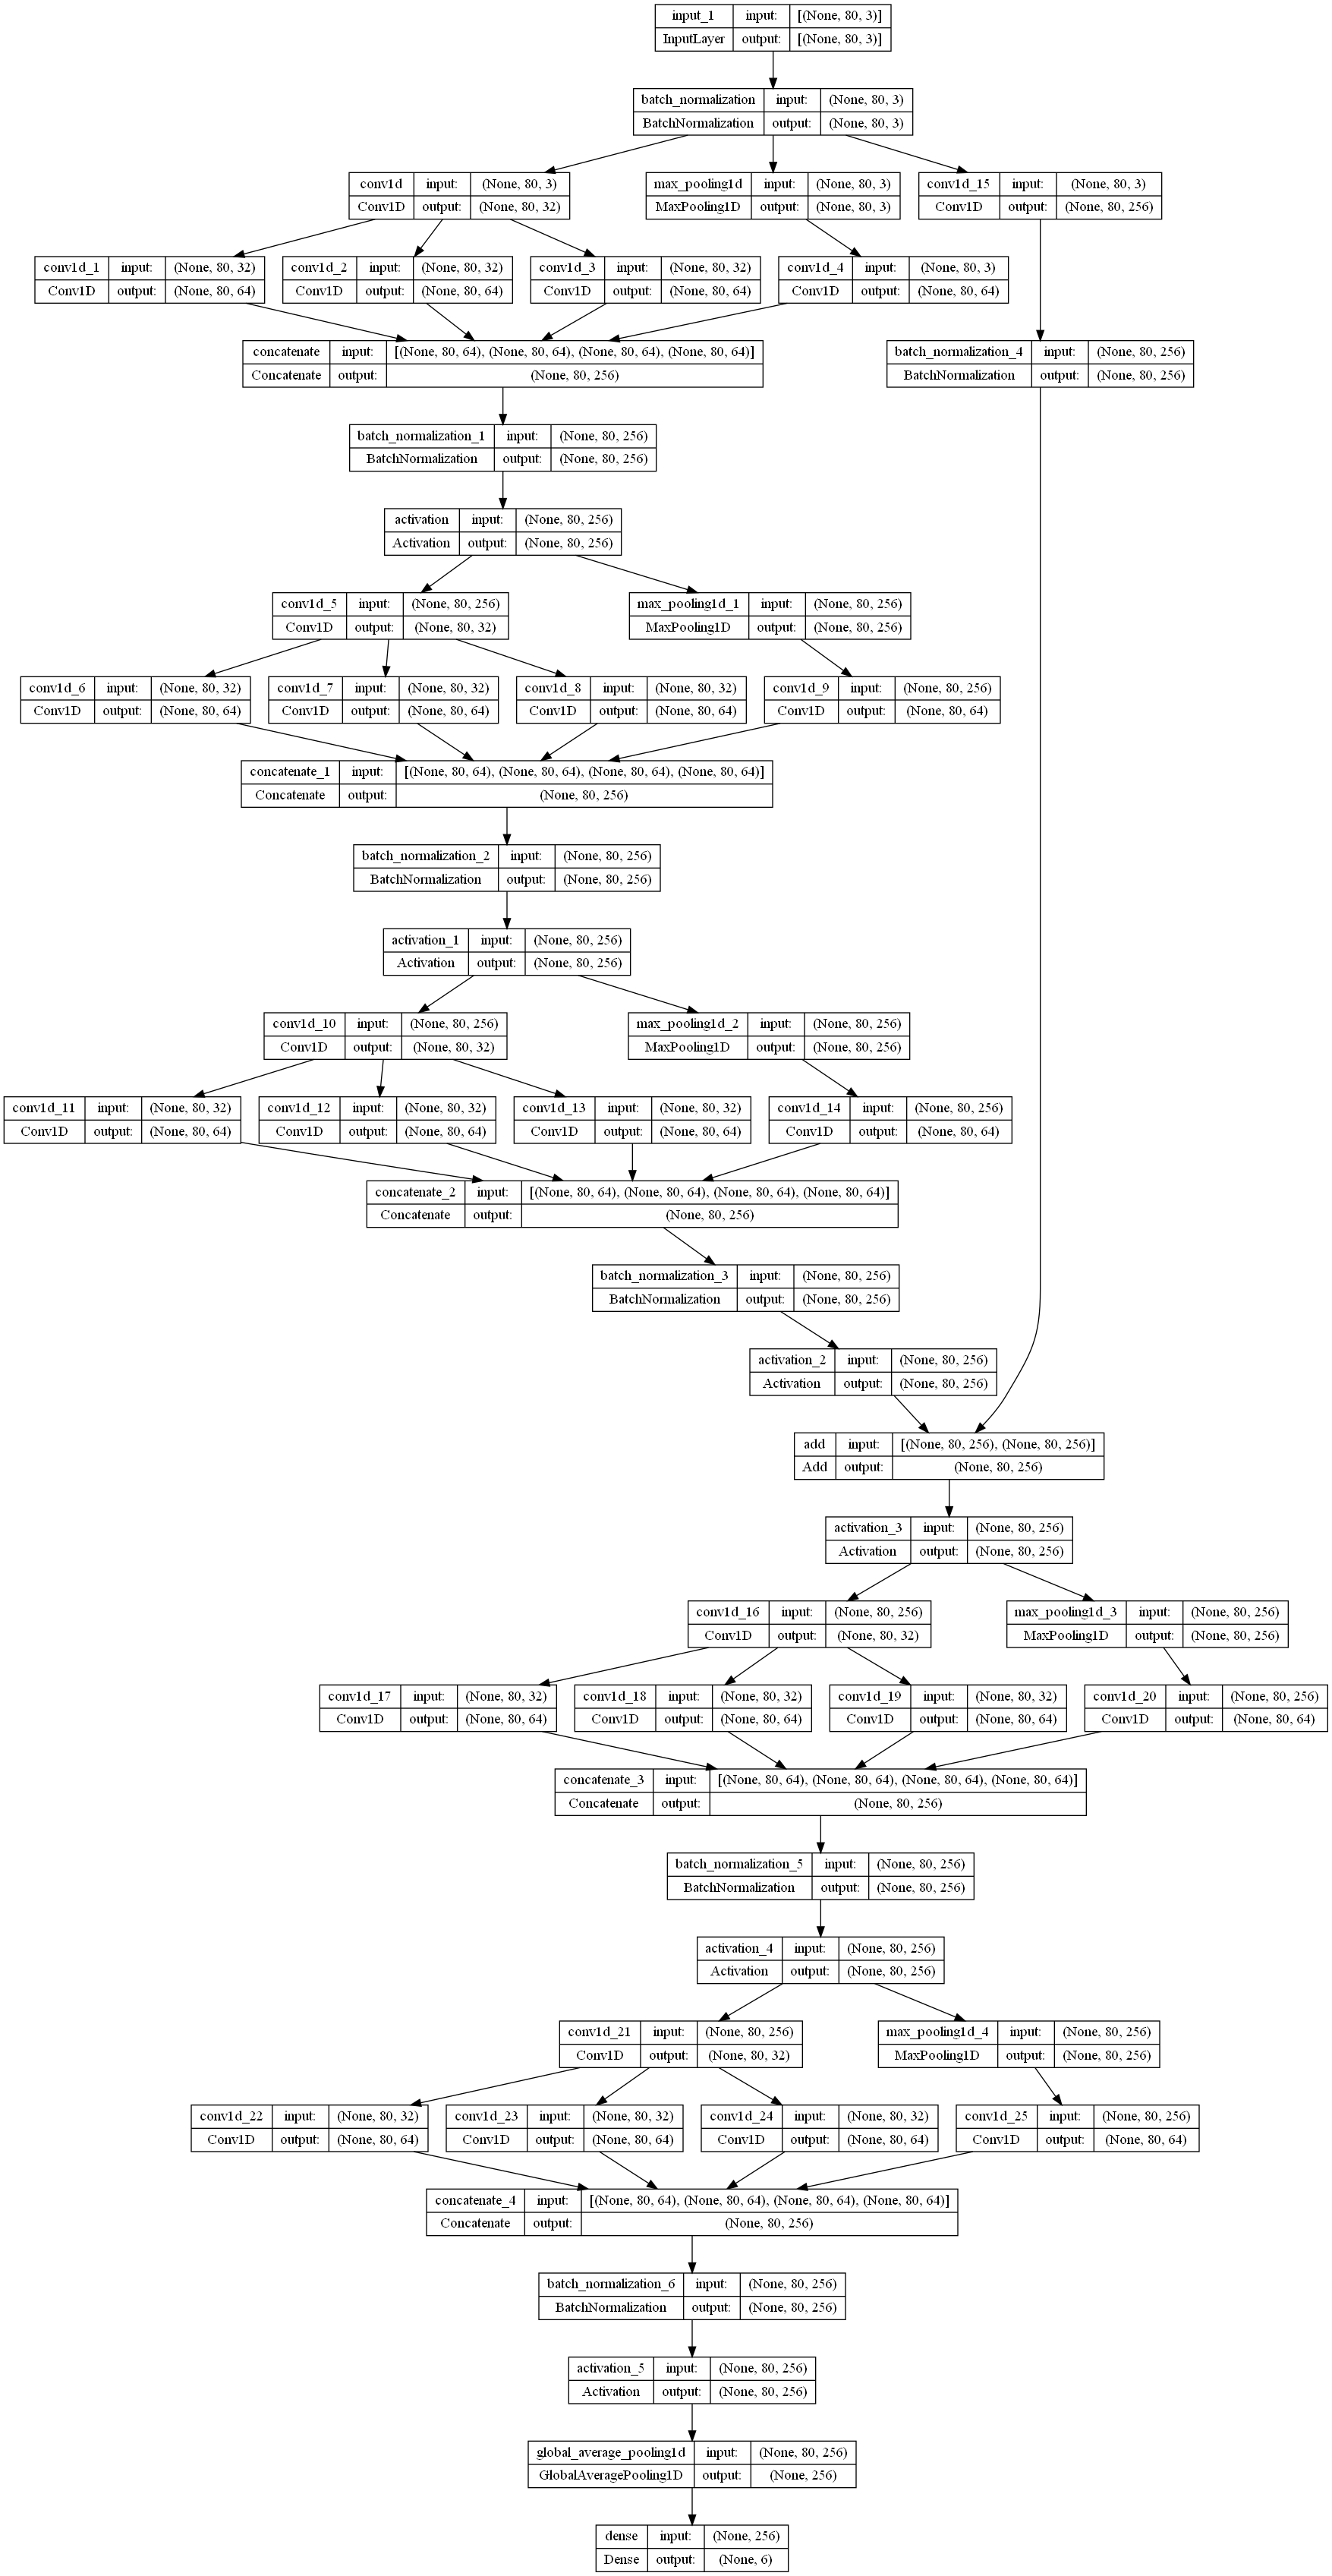

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [22]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size= 192, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
96/96 [==============================] - 164s 2s/step - loss: 2.8174 - accuracy: 0.8546 - val_loss: 1.8262 - val_accuracy: 0.6229
Epoch 2/10
96/96 [==============================] - 159s 2s/step - loss: 0.8671 - accuracy: 0.9122 - val_loss: 1.6996 - val_accuracy: 0.7704
Epoch 3/10
96/96 [==============================] - 159s 2s/step - loss: 0.8218 - accuracy: 0.9144 - val_loss: 2.4617 - val_accuracy: 0.3038
Epoch 4/10
96/96 [==============================] - 144s 1s/step - loss: 0.7851 - accuracy: 0.9156 - val_loss: 1.8281 - val_accuracy: 0.5885
Epoch 5/10
96/96 [==============================] - 147s 2s/step - loss: 0.7046 - accuracy: 0.9204 - val_loss: 1.5545 - val_accuracy: 0.6057
Epoch 6/10
96/96 [==============================] - 156s 2s/step - loss: 0.6795 - accuracy: 0.9193 - val_loss: 1.1846 - val_accuracy: 0.7483
Epoch 7/10
96/96 [==============================] - 145s 2s/step - loss: 0.5987 - accuracy: 0.9268 - val_loss: 0.9622 - val_accuracy: 0.7689
Epoch 8/10
96

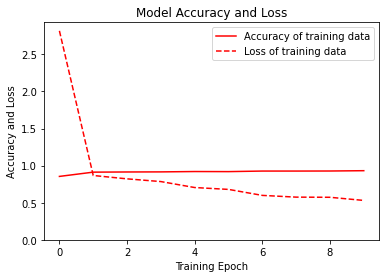

223/223 [==============================] - 10s 42ms/step
              precision    recall  f1-score   support

           0       0.24      0.25      0.25       723
           1       1.00      0.30      0.46      1989
           2       0.53      1.00      0.69       453
           3       0.00      0.00      0.00       403
           4       0.18      0.95      0.31       799
           5       0.92      0.26      0.40      2751

    accuracy                           0.38      7118
   macro avg       0.48      0.46      0.35      7118
weighted avg       0.71      0.38      0.39      7118



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
print(classification_report(y_test, max_y_pred_test))